In [73]:
import math
import os
import pandas as pd
from IPython.display import Audio
import pickle
import glob
import os.path
from tqdm import tqdm
import scipy
from scipy.io.wavfile import write
import shutil
from collections import defaultdict
from matplotlib import pyplot as plt

In [35]:
GT_SAMPLE_RATE = 16000

In [36]:
HIFIGAN_SAMPLE_RATE = 22050

In [37]:
pd.set_option('display.max_columns', None)

In [38]:
def load_cache(cache_path):
    if os.path.exists(cache_path):
        with open(cache_path, "rb") as f:
            cache = pickle.load(f)
        print("loaded cache at", cache_path)
    else:
        print("WARNING NO CACHE NOT FOUND AT", cache_path, 'returning empty one')
        cache = {}
    return cache

spelling2vocoded_audio = load_cache("/home/s1785140/rlspeller/caches/spelling2vocoded_audio_cache.pkl",)

loaded cache at /home/s1785140/rlspeller/caches/spelling2vocoded_audio_cache.pkl


In [39]:
dataframe_outdir = os.path.join(os.getcwd(), 'results')
os.listdir(dataframe_outdir)

['test_dump_feats',
 'distances_df_16-03-2023_16:08:58.pkl',
 'distances_df_16-03-2023_16:12:59.pkl',
 'distances_df_16-Mar-2023_16:16:57.pkl',
 'distances_df_16-Mar-2023_16:42:14.pkl',
 'distances_df_16-Mar-2023_16:46:34.pkl',
 'distances_df_16-Mar-2023_16:55:34.pkl',
 'distances_df_16-Mar-2023_16:59:52.pkl',
 'distances_df_16-Mar-2023_17:14:10.pkl',
 'distances_df_17-Mar-2023_00:55:15.pkl',
 'distances_df_27-Mar-2023_12:38:45.pkl',
 'distances_df_27-Mar-2023_13:04:06.pkl',
 'distances_df_27-Mar-2023_15:06:19.pkl',
 'distances_df_27-Mar-2023_15:44:02.pkl',
 'distances_df_28-Mar-2023_12:52:18.pkl',
 'distances_df_28-Mar-2023_17:13:48.pkl',
 'distances_df_29-Mar-2023_11:10:08.pkl',
 'distances_df_31-Mar-2023_20:50:35.pkl',
 'distances_df_01-Apr-2023_13:05:28.pkl',
 'distances_df_experiment1.pkl']

In [40]:
# get latest created file in output folder 
def get_latest_file(in_dir, file_type):
    files = glob.glob(os.path.join(in_dir, file_type))
    return max(files, key=os.path.getctime)

df_to_load = ""
# df_to_load = '/disk/nfs/ostrom/s1785140/rlspeller/results/distances_df_17-Mar-2023_00:55:15.pkl' # first big test of pipeline
# df_to_load = '/disk/nfs/ostrom/s1785140/rlspeller/results/distances_df_27-Mar-2023_13:04:06.pkl' # first test of 1000 spellings per wordtype (no dropout)
# df_to_load = '/disk/nfs/ostrom/s1785140/rlspeller/results/distances_df_experiment1.pkl'

if not df_to_load:
    df_to_load = get_latest_file(dataframe_outdir, r'*.pkl')
    
df_to_load

'/disk/nfs/ostrom/s1785140/rlspeller/results/distances_df_experiment1.pkl'

In [41]:
# load dataframe from disk
df = pd.read_pickle(df_to_load)

In [42]:
distance_columns = df.columns[df.columns.str.contains("::")]
for col in distance_columns:
    print(col)
    new_col = col.replace('::', '==')
    df.rename(columns={col: new_col}, inplace=True)
df.columns[df.columns.str.contains("==")]

mfcc::Distance(Euclidean)
mfcc::Distance(Euclidean)::w_SL_Penalty
hubert-raw::Distance(Cosine)
hubert-raw::Distance(Cosine)::w_SL_Penalty
hubert-soft::Distance(Cosine)
hubert-soft::Distance(Cosine)::w_SL_Penalty
hubert-discrete-code::Distance(Levenshtein)
hubert-discrete-code::Distance(Levenshtein)::w_SL_Penalty
hubert-discrete-centroid::Distance(Cosine)
hubert-discrete-centroid::Distance(Cosine)::w_SL_Penalty


Index(['mfcc==Distance(Euclidean)', 'mfcc==Distance(Euclidean)==w_SL_Penalty',
       'hubert-raw==Distance(Cosine)',
       'hubert-raw==Distance(Cosine)==w_SL_Penalty',
       'hubert-soft==Distance(Cosine)',
       'hubert-soft==Distance(Cosine)==w_SL_Penalty',
       'hubert-discrete-code==Distance(Levenshtein)',
       'hubert-discrete-code==Distance(Levenshtein)==w_SL_Penalty',
       'hubert-discrete-centroid==Distance(Cosine)',
       'hubert-discrete-centroid==Distance(Cosine)==w_SL_Penalty'],
      dtype='object')

In [43]:
# exclude wordtypes 
# i.e. 
    # because they are not pronounced incorrectly by TTS
    # bad alignment
bad_alignments = [
    'subpoenaed',
    'deprecated',
    'habitually',
    'hogshead',
    'schleiden',
    'sabotage',
    'schoeffer',
] 

pronounced_ok_by_tts = [
    # don't add any words here! we are ok if TTS pronounces original spelling ok, we might be able to find a better pronunciation with our spelling pipeline anyway
]
    
wordtypes_to_exclude = bad_alignments + pronounced_ok_by_tts

In [44]:
print("pre-filter df has", len(df['wordtype'].unique()), "total wordtypes")

pre-filter df has 246 total wordtypes


In [45]:
df = df[~df['wordtype'].isin(wordtypes_to_exclude)]

In [46]:
print("filtered df has", len(df['wordtype'].unique()), "total wordtypes")

filtered df has 246 total wordtypes


# display n-best ranked spellings for a distance metric

In [47]:
# add column to indicate whether it is original spelling or not
new_col_idx = 1 + df.columns.get_loc('respelling') # insert after respelling column
new_col_name = 'is_orig'
df.insert(new_col_idx, new_col_name, df['wordtype'] == df['respelling'])

In [48]:
wordtype2numspellings = {} #excludes original spelling
for wordtype in df['wordtype'].unique():
    count = len(df[(df['wordtype'] == wordtype) & (df['is_orig'] == False)])
    wordtype2numspellings[wordtype] = count

In [49]:
wordtypes = df["wordtype"].unique()
print(len(wordtypes))
wordtypes

246


array(['conducive', 'patriotic', 'exertion', 'exhaustion', 'soubriquet',
       'borsippa', 'minorities', 'fatigues', 'narcotics', 'monitored',
       'discouraging', 'spirituous', 'czolgosz', 'psychiatrist',
       'brochure', 'juveniles', 'ostentatious', 'inveigled', 'subsidiary',
       'nonpartisan', 'sepulchres', 'gonzalez', 'injuring', 'phosphorus',
       'penknife', 'collared', 'jealousy', 'courtesy', 'shropshire',
       'pecuniary', 'gloucester', 'erasures', 'usurious', 'silhouette',
       'alleging', 'juvenile', 'executor', 'nourished', 'dastardly',
       'exhorted', 'uncombed', 'overseer', 'etiquette', 'paradise',
       'itinerary', 'nauseous', 'exertions', 'adhering', 'brougham',
       'prerogative', 'exorbitant', 'vestiges', 'southern', 'hereford',
       'beaumont', 'baronetcy', 'ferocious', 'horizontal', 'amusement',
       'courtyards', 'brazilian', 'launched', 'morality', 'recalcitrant',
       'punitive', 'nicholas', 'spiritual', 'tocqueville', 'aspirants',
     

In [50]:
# Select column that we sort by

# distance_metric_col_name = "mfcc==Distance(Euclidean)"
# distance_metric_col_name = "hubert-raw==Distance(Cosine)"
distance_metric_col_name = "hubert-soft==Distance(Cosine)"
# distance_metric_col_name = "hubert-discrete-code==Distance(Levenshtein)"
# distance_metric_col_name = "hubert-discrete-centroid==Distance(Cosine)"

use_SL_Penalty = False
if use_SL_Penalty:
    distance_metric_col_name += "==w_SL_Penalty"
    
print(f"Using {distance_metric_col_name} to rank spellings")

Using hubert-soft==Distance(Cosine) to rank spellings


In [51]:
def get_n_best_df(df, distance_metric_col_name, n_spellings_per_token_id=1, show_smallest=True):
    # Display N-best ranked respellings per original input audio (excluding original spellings!)
    if show_smallest:
        n_best_lambda_fn = lambda x: x.nsmallest(n_spellings_per_token_id, distance_metric_col_name)
    else:
        n_best_lambda_fn = lambda x: x.nlargest(n_spellings_per_token_id, distance_metric_col_name)

    original_spellings_mask = df['wordtype'] == df['respelling']
    original_spellings_df = df[original_spellings_mask]
    inverted_mask = ~original_spellings_mask
    no_orig_spellings_df = df[inverted_mask]
    n_best_df = no_orig_spellings_df.groupby('wordtype', group_keys=False).apply(n_best_lambda_fn)
    return n_best_df, original_spellings_df

## add nbest ranking to df

In [52]:
LEN_OF_NBEST_LIST = 1000

# for each word in dataframe, add a new column that indicates its ASR nbest ranking
for w in tqdm(df['wordtype'].unique()):
    for i, df_idx in enumerate(df[df['wordtype'] == w].index[:LEN_OF_NBEST_LIST], 1):
        df.loc[df_idx, "asr_nbest_rank"] = i

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 246/246 [00:43<00:00,  5.65it/s]


## sort wordtypes by distance gap 

In [53]:
# add back original spellings and sort by distance and also by gap between best spelling and original spelling
n_best_df, original_spellings_df = get_n_best_df(df, distance_metric_col_name, n_spellings_per_token_id=1)
n_best_df = pd.concat([n_best_df, original_spellings_df], ignore_index=True)

In [54]:
# Produce a single dataframe where rows of the same wordtype are grouped
# within a group they are ordered by the distance metric
# and the order of the groups is determined by the gap between the distance value of the best spelling and the original spelling

# add new col for distace_gap
distance_gap_col_name = f"{distance_metric_col_name}==distance_gap"
n_best_df.insert(1 + n_best_df.columns.get_loc(distance_metric_col_name), distance_gap_col_name, None)

In [55]:
wordtype2df = {}
wordtype2maximum_distance_gap = {}

# get each sub_df corresponding to wordtype
wordtypes = n_best_df['wordtype'].unique()
for wordtype in wordtypes:
    wordtype_df = n_best_df[n_best_df['wordtype'] == wordtype]
    
    # for each spelling calculate its distance gap from the original wordtype (calc'd against same GT token_id!)
    max_distance_gap = -math.inf
    for i in wordtype_df[wordtype_df['wordtype'] == wordtype].index:
        token_id = wordtype_df.loc[i, 'token_id']

        # this should be the correct code! but we haven't guaranteed that we have calculated distance from original spelling to each respective token_id yet!!!
        # original_spelling_distance = wordtype_df[(wordtype_df['wordtype'] == wordtype) & (wordtype_df['is_orig'] == True) & (wordtype_df['token_id'] == token_id)][distance_metric_col_name].item()

        # temporary code, not ideal!
        # print(wordtype_df[(wordtype_df['wordtype'] == wordtype) & (wordtype_df['is_orig'] == True)][distance_metric_col_name])
        
        # TODO fix code so this isn't needed
        if len(wordtype_df[(wordtype_df['wordtype'] == wordtype) & (wordtype_df['is_orig'] == True)].head(1)[distance_metric_col_name]) != 1:
            original_spelling_distance = -math.inf
            print('WARNING invalid wordtype', wordtype)
        else:
            original_spelling_distance = wordtype_df[(wordtype_df['wordtype'] == wordtype) & (wordtype_df['is_orig'] == True)].head(1)[distance_metric_col_name].item()

        distance_gap = original_spelling_distance - wordtype_df.loc[i, distance_metric_col_name]
        max_distance_gap = max(distance_gap, max_distance_gap)
        wordtype_df.loc[i, distance_gap_col_name] = distance_gap

    # store df into dictionary temporarily
    wordtype2df[wordtype] = wordtype_df

    # track max distance gap for each wordtype
    wordtype2maximum_distance_gap[wordtype] = max_distance_gap
    
# order wordtypes by distance
# sorted(wordtypes, key=lambda x: wordtype2maximum_distance_gap[x])
sorted_wordtype2maximum_distance_gap = dict(sorted(wordtype2maximum_distance_gap.items(), key=lambda item: item[1], reverse=True))

WARNING invalid wordtype alexander
WARNING invalid wordtype spiritual


In [56]:
# recombine dfs into big df
df_list = [wordtype2df[wordtype] for wordtype in sorted_wordtype2maximum_distance_gap.keys()]
combined_df = pd.concat(df_list)

# print n-best spellings for each wordtype

In [57]:
# current_wordtype = ""
# for token_id, wordtype, respelling, distance, orig_wav, is_orig in zip(
#     combined_df['token_id'], 
#     combined_df['wordtype'], 
#     combined_df['respelling'], 
#     combined_df[distance_metric_col_name], 
#     combined_df['orig_wav'],
#     combined_df['is_orig']
# ):
#     # new wordtype, print GT token_ids and display audios
#     if current_wordtype != wordtype:
#         current_wordtype = wordtype
        
#         # get all token_ids and orig_wavs for this wordtype
#         wordtype_df = combined_df[combined_df['wordtype'] == wordtype]
#         first_row_for_each_token_id = wordtype_df.groupby('token_id').nth(0)
        
#         str_symb_len = 75
        
#         print(str_symb_len * "=")
#         print(f" Original word aligned WAV(s) ".center(str_symb_len, '='))
#         print(str_symb_len * "=")
        
#         for index, row in first_row_for_each_token_id.iterrows():
#             token_id = index # index is now equal to token_id as we used groupby above
#             print(f"[GT - {token_id}]:")
#             display(Audio(row['orig_wav'], rate=GT_SAMPLE_RATE))
#         print(str_symb_len * "-")
#         print(f" Respellings ({wordtype2numspellings[wordtype]} in total) ".center(str_symb_len, '-'))
#         print(f" Best distance gap: {wordtype2maximum_distance_gap[wordtype]:.3f} ".center(str_symb_len, '-'))
#         print(str_symb_len * "-")
    
#     # create string to print for this respelling
#     print_str = ""
#     if is_orig:
#         print_str += f"{' '+wordtype+' ':*^35}"
#     else:
#         print_str += f" ---> {respelling=}"
#     distance_str = f" {distance:.2f} [{distance_metric_col_name}] [calc'ed vs GT: {token_id}]"
#     print_str += distance_str
#     print(print_str)
    
#     display(Audio(spelling2vocoded_audio[respelling], rate=HIFIGAN_SAMPLE_RATE))

In [58]:
# # CUSTOM FOR ONLY PRINTING GT AUDIO!!!!!!!!!!!!!!

# current_wordtype = ""
# for token_id, wordtype, respelling, distance, orig_wav, is_orig in zip(
#     combined_df['token_id'], 
#     combined_df['wordtype'], 
#     combined_df['respelling'], 
#     combined_df[distance_metric_col_name], 
#     combined_df['orig_wav'],
#     combined_df['is_orig']
# ):
#     # new wordtype, print GT token_ids and display audios
#     if current_wordtype != wordtype:
#         current_wordtype = wordtype
        
#         # get all token_ids and orig_wavs for this wordtype
#         wordtype_df = combined_df[combined_df['wordtype'] == wordtype]
#         first_row_for_each_token_id = wordtype_df.groupby('token_id').nth(0)
        
#         for index, row in first_row_for_each_token_id.iterrows():
#             token_id = index # index is now equal to token_id as we used groupby above
#             print(f"[GT - {token_id}]:")
#             display(Audio(row['orig_wav'], rate=GT_SAMPLE_RATE))


# define list of dev set and test set wordtypes in reproducible manner

In [59]:
# filter so we only keep enough for dev and test sets
dev_n = 100
test_n = 100
assert dev_n + test_n < len(df['wordtype'].unique())

In [60]:
wordtype2per = {}
for w in df['wordtype'].unique():
    per = df[df['wordtype'] == w]['per'].head(1).values[0]
    wordtype2per[w] = per

In [61]:
sorted_wordtype2per = sorted(wordtype2per.items(), key=lambda x: x[1], reverse=True)

In [62]:
# odd is test set, even is dev set
dev_set_wordtypes = set()
test_set_wordtypes = set()
for i, (w, _per) in enumerate(sorted_wordtype2per[:dev_n+test_n], 1):
    if i % 2 == 0:
        dev_set_wordtypes.add(w)
    elif i % 2 == 1:
        test_set_wordtypes.add(w)
    else:
        raise ValueError
    
assert len(dev_set_wordtypes) == dev_n, f"{len(dev_set_wordtypes)} != {dev_n}" 
assert len(test_set_wordtypes) == test_n, f"{len(test_set_wordtypes)} != {test_n}" 

In [63]:
", ".join(sorted(dev_set_wordtypes))

'allegiance, alleging, annulled, attribute, auditorium, battalion, bequeathed, boulogne, brochure, brougham, bulwarks, burchell, cadillac, calamity, caravans, cemetery, charioteers, colleagues, collegians, colonial, competitive, conducive, coughing, courtesy, cribbage, czolgosz, decorated, deterred, effluvia, epithets, european, executing, executor, exertions, exhortations, exhorted, exhorting, exonerated, experimental, fastidious, flintshire, forenoon, forgetfulness, forgiveness, frenzied, giovanni, gloucester, gloucestershire, gonzalez, hammurabi, harassed, hereford, horizontal, individuality, invoices, juvenile, juveniles, macintosh, maryland, matrices, mediterranean, mesopotamia, minarets, monitored, monsieur, narcotics, nonpartisan, nourished, oscillating, ostentatious, paradise, parasitic, parasitically, penknife, persevered, phosphoric, portuguese, premising, prerogative, presided, pugnacious, punitive, respiratory, reverend, ridicule, seleucia, sepulchre, shredded, shropshire, 

In [64]:
", ".join(sorted(test_set_wordtypes))

'adherence, adhering, advertised, alexander, alexanders, aligning, analyzed, aspirants, augmented, barouche, beaumont, boisterous, bonaventura, borsippa, capillary, champagne, clangour, collared, colonization, compromised, confided, dastardly, decorous, delicate, deutsche, discourage, ehrenberg, endorsed, engendered, entourage, erasures, erroneous, escalade, escritoire, ethelred, etiquette, eventual, executors, exertion, exhaustion, exhaustive, exhortation, exorbitant, fatigues, grimaldi, guiseppe, habitual, heiresses, heterogeneous, immature, insecure, intellectual, interred, inveigled, itinerary, jealousy, karswell, khrushchev, laughter, launched, licensed, maecenas, marseilles, merionethshire, minorities, minority, monastery, morality, mortgages, napoleon, nauseous, nicholas, obscenity, outshone, patriotic, pecuniary, peripheral, phosphorus, presides, prestige, priority, protests, psychiatrist, reservoir, respited, righteous, rothschilds, rouleaux, saccharine, sassanian, sepulchres,

## calculate statistics such as avg n-best rank of retrieved spellings

mfcc==Distance(Euclidean)


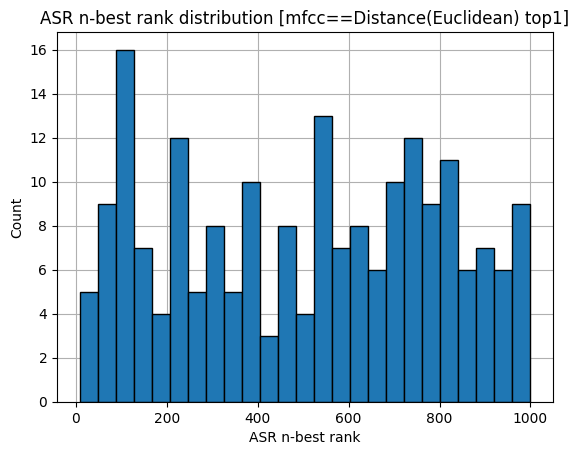

hubert-raw==Distance(Cosine)


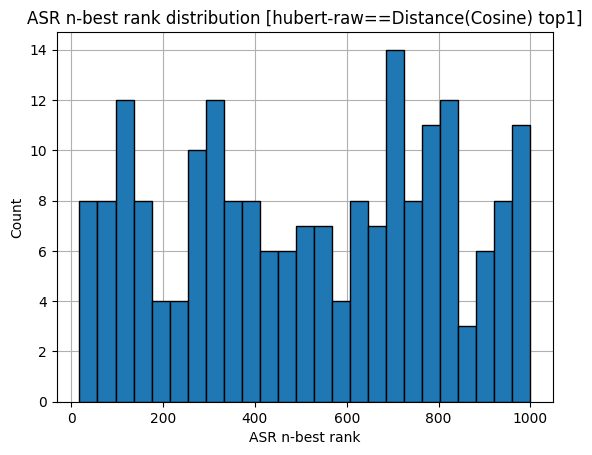

hubert-soft==Distance(Cosine)


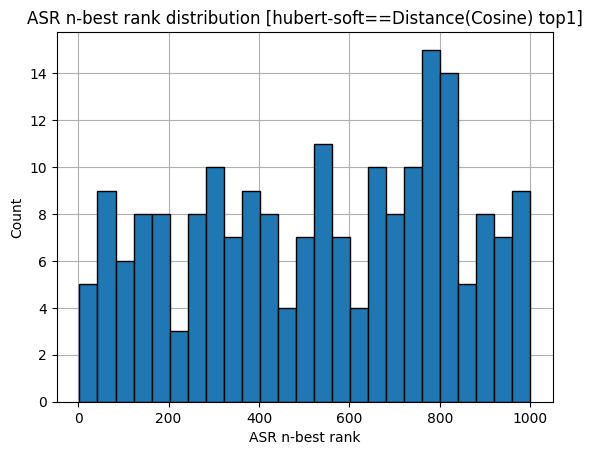

hubert-discrete-code==Distance(Levenshtein)


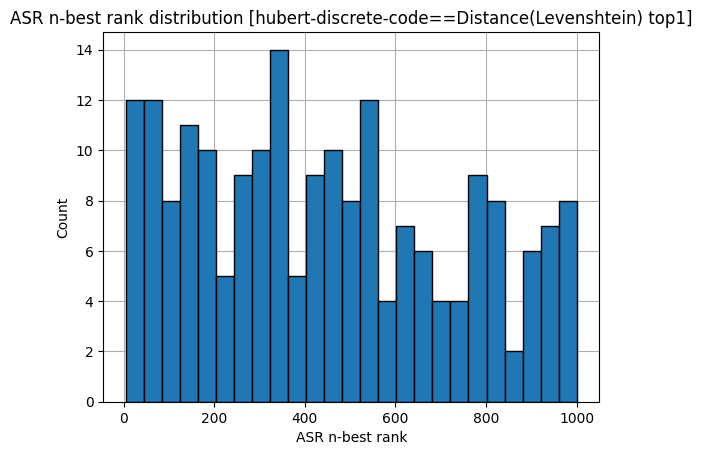

hubert-discrete-centroid==Distance(Cosine)


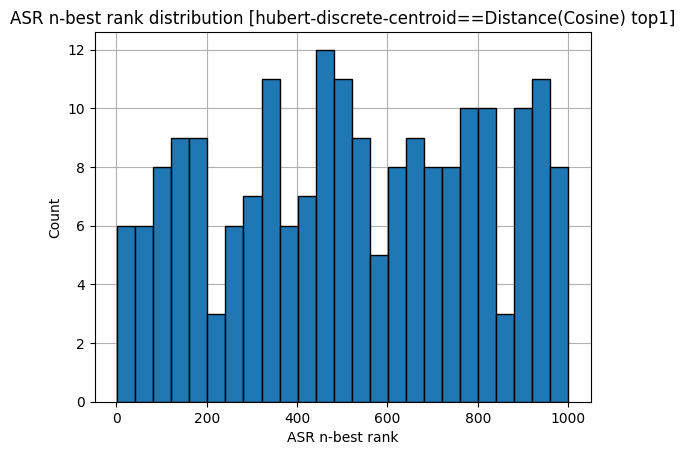

In [88]:
# N_SPELLINGS_PER_TOKEN_ID = 1 # acousticrank1
N_SPELLINGS_PER_TOKEN_ID = 5 # acousticrank5 (human in the loop)
NUM_BINS = 25

for distance_metric_col_name in [
    'mfcc==Distance(Euclidean)',
    'hubert-raw==Distance(Cosine)',
    'hubert-soft==Distance(Cosine)',
    'hubert-discrete-code==Distance(Levenshtein)',
    'hubert-discrete-centroid==Distance(Cosine)',
]:
    print(distance_metric_col_name)
    only_dev_test_df = df[df['wordtype'].isin(dev_set_wordtypes | test_set_wordtypes)]
    n_best_df, _ = get_n_best_df(only_dev_test_df, distance_metric_col_name, n_spellings_per_token_id=N_SPELLINGS_PER_TOKEN_ID)

    # plot histogram of asr_nbest_rank
    n_best_df['asr_nbest_rank'].hist(edgecolor='black', bins=NUM_BINS)
    plt.xlabel('ASR n-best rank')
    plt.ylabel('Count')
    plt.title(f'ASR n-best rank distribution [{distance_metric_col_name} top{N_SPELLINGS_PER_TOKEN_ID}]')
    plt.gca().set_axisbelow(True)
    plt.show()

In [66]:
raise ValueError

ValueError: 

# save files to disk to create listening test for experiment 1

- save wavs for each ranking metric to its own folder 
- save GT wavs
- save url lists (used by create_ab_url_lists_for_qualtreats.ipynb)

In [ ]:
distances_to_save = [
    "mfcc==Distance(Euclidean)",
    "hubert-raw==Distance(Cosine)",
    "hubert-soft==Distance(Cosine)",
    "hubert-discrete-code==Distance(Levenshtein)",
    "hubert-discrete-centroid==Distance(Cosine)",
]

# for creating url lists that are used to create qualtreats tests
conditionname2wavlist = defaultdict(list)

# save dev set spelling wavs to disk
for i, w in enumerate(tqdm(sorted(dev_set_wordtypes)), 1):
    for distance_metric_col_name in distances_to_save:
        # retrieve best ranked spelling for wordtype
        n_best_df, original_spellings_df = get_n_best_df(df, distance_metric_col_name, n_spellings_per_token_id=1)
        best_ranked_spelling = n_best_df[n_best_df['wordtype'] == w]['respelling'].values[0]
        wav = spelling2vocoded_audio[best_ranked_spelling]

        # create outdir
        outdir = os.path.join("listening_tests", 'experiment1', distance_metric_col_name)
        os.makedirs(outdir, exist_ok=True)
        wavfilename = f"{i}_{w}_{best_ranked_spelling}.wav"
        outpath = os.path.join(outdir, wavfilename)

        # save in outdir
        write(outpath, HIFIGAN_SAMPLE_RATE, wav)
        
        conditionname2wavlist[distance_metric_col_name].append(wavfilename)
        
    ## save GT audio for wordtypes to disk
    # get path to GT wav from df 
    orig_wav_paths = df[df['wordtype'] == w]['orig_wav'].unique()
    assert len(orig_wav_paths) == 1 # should be the case since we only have one token_id per wordtype
    orig_wav_path = orig_wav_paths[0]
    # use shell/bash to copy file to destination folder
    outdir = os.path.join("listening_tests", 'experiment1', 'groundtruth')
    os.makedirs(outdir, exist_ok=True)
    wavfilename = f"{i}_{os.path.basename(orig_wav_path)}"
    outpath = os.path.join(outdir, wavfilename)
    shutil.copy(orig_wav_path, outpath)
    
    conditionname2wavlist['groundtruth'].append(wavfilename)

In [ ]:
# save url_lists to disk, ready for qualtreats

# example URL https://jonojace.github.io/IS22-speech-audio-corrector-samples/SAC-grapheme-input/1-how is afghan pronounced.wav
url_folder = "https://jonojace.github.io/SSW23-asr-speller-samples"
url_lists_outdir = os.path.join("listening_tests", 'experiment1', 'url_lists')
os.makedirs(url_lists_outdir, exist_ok=True)

for condition_name, wavlist in conditionname2wavlist.items():
    urls = []
    for wavfilename in wavlist:
        full_url = f"{url_folder}/{condition_name}/{wavfilename}"
        urls.append(full_url)
    
    # write url list to disk
    with open(os.path.join(url_lists_outdir, f"{condition_name}.txt"), 'w') as f:
        f.write("\n".join(urls))

## run the following command in bash from your laptop to transfer files to your local mac

```bash
SOURCE=s1785140@escience6.inf.ed.ac.uk:/home/s1785140/rlspeller/listening_tests/
DEST=/Users/jonojace/asr_speller/listening_tests/
mkdir -p $DEST
rsync -avu $SOURCE $DEST
```

# save files to disk to create listening test for experiment 2

- GT audio
- original_spellings
- asr_1000_best_acoustic_autorank_top1
- asr_1000_best_acoustic_autorank_top5

In [ ]:
### create all outdirs
exp2_conditions = [
    "asr_1000_best_acoustic_autorank_top1",
    "asr_1000_best_acoustic_autorank_top5",
]

condition2outdir = {
    condition: os.path.join("listening_tests", 'experiment2', EXP2_DISTANCE_NAME, condition)
    for condition in exp2_conditions
}

condition2outdir["original_spellings"] = os.path.join("listening_tests", 'experiment2', 'original_spellings')
condition2outdir["groundtruth"] = os.path.join("listening_tests", 'experiment2', 'groundtruth')
condition2outdir["asr_1_best"] = os.path.join("listening_tests", "experiment2", "asr_1_best")
condition2outdir["asr_5_best_acoustic"] = os.path.join("listening_tests", "experiment2", "asr_5_best_acoustic")
condition2outdir["asr_5_best_no_acoustic"] = os.path.join("listening_tests", "experiment2", "asr_5_best_no_acoustic")

for condition, outdir in condition2outdir.items():
    os.makedirs(outdir, exist_ok=True)

In [ ]:
NUM_SPELLINGS_PER_WORDTYPE = 5
EXP2_DISTANCE_NAME = "hubert-raw==Distance(Cosine)"

for i, w in enumerate(tqdm(sorted(test_set_wordtypes)), 1):
    n_best_df, original_spellings_df = get_n_best_df(df, EXP2_DISTANCE_NAME, n_spellings_per_token_id=NUM_SPELLINGS_PER_WORDTYPE)
    best_ranked_spellings = n_best_df[n_best_df['wordtype'] == w]['respelling'].values
    assert len(best_ranked_spellings) == NUM_SPELLINGS_PER_WORDTYPE
    best_ranked_spelling = best_ranked_spellings[0] # since these are ranked in order of the distance!

    ### save wavs for asr_1000_best_acoustic_autorank_top1 and top5
    # top 1
    wavfilename = f"{i}_{w}_{best_ranked_spelling}.wav"
    outpath = os.path.join(condition2outdir['asr_1000_best_acoustic_autorank_top1'], wavfilename)
    write(outpath, HIFIGAN_SAMPLE_RATE, spelling2vocoded_audio[best_ranked_spelling])
    # top 5
    for spelling in best_ranked_spellings:
        wavfilename = f"{i}_{w}_{spelling}.wav"
        outpath = os.path.join(condition2outdir['asr_1000_best_acoustic_autorank_top5'], wavfilename)
        write(outpath, HIFIGAN_SAMPLE_RATE, spelling2vocoded_audio[spelling])

    ### save wav original spelling
    wavfilename = f"{i}_{w}.wav"
    outpath = os.path.join(condition2outdir['original_spellings'], wavfilename)
    write(outpath, HIFIGAN_SAMPLE_RATE, spelling2vocoded_audio[w])
    
    ### save wav for GT
    orig_wav_paths = df[df['wordtype'] == w]['orig_wav'].unique()
    assert len(orig_wav_paths) == 1 # should be the case since we only have one token_id per wordtype
    orig_wav_path = orig_wav_paths[0]
    # use shell/bash to copy file to destination folder
    wavfilename = f"{i}_{os.path.basename(orig_wav_path)}"
    outpath = os.path.join(condition2outdir["groundtruth"], wavfilename)
    shutil.copy(orig_wav_path, outpath)

Audios for ASR nbest:
- asr_1_best
- asr_5_best_acoustic
- asr_5_best_no_acoustic

Below approach works since we can recover nbest rank for each respelling from its index in pandas df, since df 
conserves the order from which we added items into it

In [ ]:
def save_wav(outpath, wav_data):
    write(outpath, HIFIGAN_SAMPLE_RATE, wav_data)

In [ ]:
for i, w in enumerate(tqdm(sorted(test_set_wordtypes)), 1):
    # get asr nbest from dataframe
    n_best_df = df[df['wordtype'] == w][:NUM_SPELLINGS_PER_WORDTYPE]
    assert n_best_df["asr_nbest_rank"].max() == 5.0
    assert n_best_df["asr_nbest_rank"].min() == 1.0

    # save wavs to disk
    # for spelling in 
    for df_idx in n_best_df.index:
        spelling = df.loc[df_idx, "respelling"]
        wavfilename = f"{i}_{w}_{spelling}.wav"

        outpath = os.path.join(condition2outdir['asr_5_best_acoustic'], wavfilename)
        save_wav(outpath, spelling2vocoded_audio[spelling])
        outpath = os.path.join(condition2outdir['asr_5_best_no_acoustic'], wavfilename)
        save_wav(outpath, spelling2vocoded_audio[spelling])

        if df.loc[df_idx, "asr_nbest_rank"] == 1.0:
            outpath = os.path.join(condition2outdir['asr_1_best'], wavfilename)
            save_wav(outpath, spelling2vocoded_audio[spelling])

## copy wavs back to laptop for filtering of wavs (for asr_5_best_acoustic and asr_1000_best_acoustic_autorank_top5)

```bash
SOURCE=s1785140@escience6.inf.ed.ac.uk:/home/s1785140/rlspeller/listening_tests/
DEST=/Users/jonojace/asr_speller/listening_tests/
mkdir -p $DEST
rsync -avu $SOURCE $DEST
```

## create url lists from folders of wav files

before this step, ensure that you choose the best one for top 5 systems!!! (delete the ones that are not as good)

In [ ]:
    
# save url_lists to disk, ready for qualtreats
# example URL https://jonojace.github.io/IS22-speech-audio-corrector-samples/SAC-grapheme-input/1-how is afghan pronounced.wav
url_folder = "https://jonojace.github.io/SSW23-asr-speller-samples"
url_lists_outdir = os.path.join("listening_tests", 'experiment1', 'url_lists')
os.makedirs(url_lists_outdir, exist_ok=True)

for condition_name, wavlist in conditionname2wavlist.items():
    urls = []
    for wavfilename in wavlist:
        full_url = f"{url_folder}/{condition_name}/{wavfilename}"
        urls.append(full_url)
    
    # write url list to disk
    with open(os.path.join(url_lists_outdir, f"{condition_name}.txt"), 'w') as f:
        f.write("\n".join(urls))

## run the following command in bash from your laptop to transfer files to your local mac

```bash
SOURCE=s1785140@escience6.inf.ed.ac.uk:/home/s1785140/rlspeller/listening_tests/
DEST=/Users/jonojace/asr_speller/listening_tests/
mkdir -p $DEST
rsync -avu $SOURCE $DEST
```